In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import anguilla.hypervolume as hv
from anguilla.fitness.benchmark import DTLZ1, DTLZ2, ZDT4P, IHR1
from anguilla.optimizers.mocma import MOCMA, MOParameters

In [3]:
def population_plot(fn_cls, n_dimensions, n_trials=5, max_evaluations=1000, ref_point=None, rng=None, initial_step_size=1.0, n_parents=10):
    parameters = MOParameters(n_dimensions=n_dimensions, initial_step_size=initial_step_size, n_parents=n_parents)
    initial = np.zeros((n_trials, n_parents, 2))
    final = np.zeros((n_trials, n_parents, 2))
    for trial in range(n_trials):
        optimizer = MOCMA(parameters, rng=rng, ref_point=ref_point)
        fn = fn_cls(parameters.n_dimensions, rng=rng)
        if fn.n_objectives != 2:
            fn.n_objectives = 2
        archive = optimizer.create_archive(fn)
        initial[trial, :, :] = archive.parent_fitness
        while fn.evaluation_count < max_evaluations:
            optimizer.ask(archive)
            archive.offspring_fitness[:], archive.offspring_penalized_fitness[:] = fn.evaluate_with_penalty(archive.offspring_points)
            optimizer.rank(archive, fn.evaluation_count)
            optimizer.tell(archive)
        final[trial, :, :] = archive.parent_fitness
    
    fig = plt.figure(figsize=(8, 4))
    axs = fig.subplots(1, 2)

    for trial in range(n_trials):
        color = None
        for i in range(n_parents):
            if color is None:
                p = axs[0].plot(initial[trial, i, 0], initial[trial, i, 1], marker='o')
                color = p[0].get_color()
            else:
                axs[0].plot(initial[trial, i, 0], initial[trial, i, 1], marker='o', color=color, alpha=0.5)
            axs[1].plot(final[trial, i, 0], final[trial, i, 1], marker='o', color=color, alpha=0.5)
    
    fig.suptitle(f"Population plot for {fn.name} \
                   \n dimensions = {n_dimensions}, objectives={fn.n_objectives}, parents={n_parents}, trials={n_trials}, max_evaluations={max_evaluations}")
    axs[0].set_ylabel('Second objective')
    axs[0].set_xlabel('First objective')
    axs[1].set_ylabel('Second objective')
    axs[1].set_xlabel('First objective')
    axs[0].set_title('Initial front')
    axs[1].set_title('Final front')
    fig.tight_layout()

    return fig
    
        
def check_hypervolume(fn_cls, n_dimensions, n_objectives, n_parents=10, max_evaluations=1000, ref_point=np.array([11., 11.])):
    rng = np.random.default_rng()
    parameters = MOParameters(n_dimensions=n_dimensions, initial_step_size=1.0, n_parents=n_parents)
    fn = fn_cls(parameters.n_dimensions, n_objectives, rng)
    optimizer = MOCMA(parameters, rng=rng, ref_point=ref_point)
    # Similar to optimizer.init(fn) in Shark 
    archive = optimizer.create_archive(fn)

    print('Initial: ', hv.calculate(archive.parent_fitness, ref_point))
    
    while fn.evaluation_count < max_evaluations:
        # Produce new offspring
        optimizer.ask(archive)
        # Evaluate offspring search points
        archive.offspring_fitness[:], archive.offspring_penalized_fitness[:] = fn.evaluate_with_penalty(archive.offspring_points)
        # Perform the two-level sorting and mark which are selected
        optimizer.rank(archive, fn.evaluation_count)
        # Perform adaptation and environmental selection
        optimizer.tell(archive)

    print('Final: ', hv.calculate(archive.parent_fitness, ref_point))
    print('--')

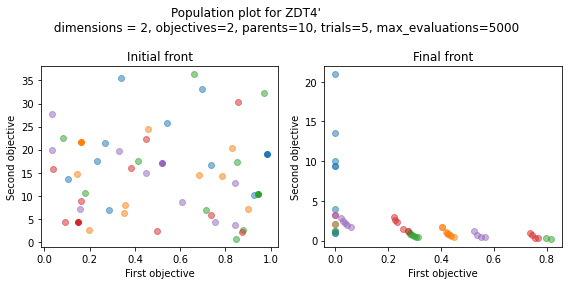

In [4]:
fig = population_plot(ZDT4P, 2, n_trials=5, n_parents=10, max_evaluations=5000)
fig.savefig('zdt4p.pdf')

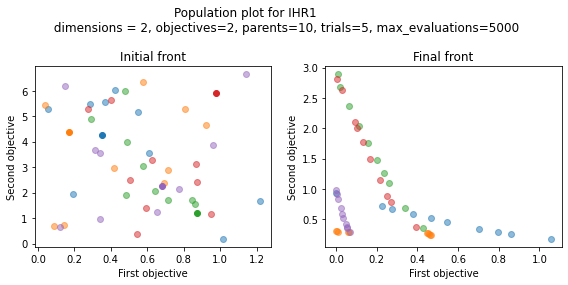

In [5]:
fig = population_plot(IHR1, 2, n_trials=5, n_parents=10, max_evaluations=5000)
fig.savefig('ihr1-n2.pdf')

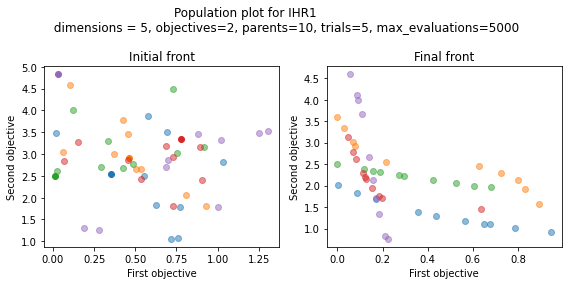

In [6]:
fig = population_plot(IHR1, 5, n_trials=5, n_parents=10, max_evaluations=5000)
fig.savefig('ihr1-n5.pdf')

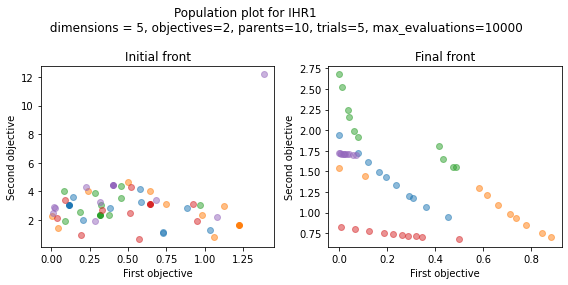

In [7]:
fig = population_plot(IHR1, 5, n_trials=5, n_parents=10, max_evaluations=10000)
fig.savefig('ihr1-n5-t10000.pdf')

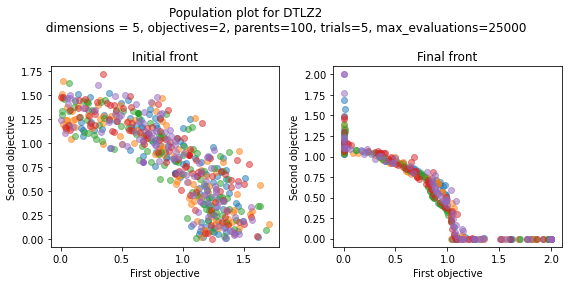

In [8]:
fig = population_plot(DTLZ2, 5, n_trials=5, n_parents=100, max_evaluations=25000, ref_point=np.array([11., 11.]))
fig.savefig('dtlz2-p100.pdf')

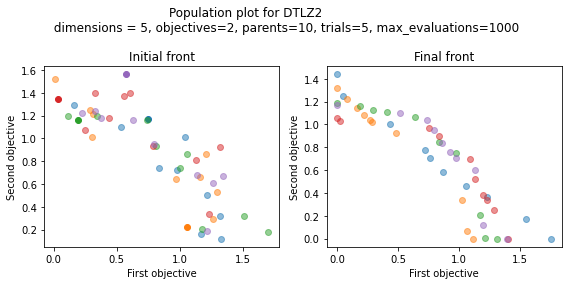

In [9]:
fig = population_plot(DTLZ2, 5, n_trials=5, n_parents=10, max_evaluations=1000, ref_point=np.array([11., 11.]))
fig.savefig('dtlz2-p10.pdf')

# DTZL2

In [10]:
for i in range(5):
    check_hypervolume(DTLZ2, 5, 2, n_parents=10, max_evaluations=1000)

Initial:  114.81002132469135
Final:  117.69591611673297
--
Initial:  114.17211755224655
Final:  119.73177869563561
--
Initial:  114.22227807189823
Final:  119.7107951189354
--
Initial:  115.75969663030892
Final:  119.37464464760232
--
Initial:  113.33808753319357
Final:  119.73251479378344
--
